<div align="right">  
    Grupo 13  
    
    André Neves da Costa - A95869 
    Filipe José Silva Castro - A96156 
</div>

# Variáveis de input

+ **V0** $\rightarrow$ velocidade inicial das rodas e do corpo no veículo

# Constantes

+ **P** $\rightarrow$ Peso do veículo
+ **c** $\rightarrow$ Constante de proporcionalidade usada nos modos FREE e BLOCKED
+ **c_stopping** $\rightarrow$ Constante de proporcionalidade usada no modo STOPPING
+ **a** $\rightarrow$ Constante de atrito usada nos modos FREE e STOPPING
+ **a_blocked** $\rightarrow$ Constante de atrito usada no modo BLOCKED
+ **tlimit** $\rightarrow$ Limite do timer usado nos modos FREE e BLOCKED
+ **erro** $\rightarrow$ Valor que serve como margem de erro para determinar quando as rodas ou o corpo do veículo ficam com 0 de velocidade

# Autómato híbrido

O seguinte autómato híbrido modela o comportamento de um ABS de um carro:

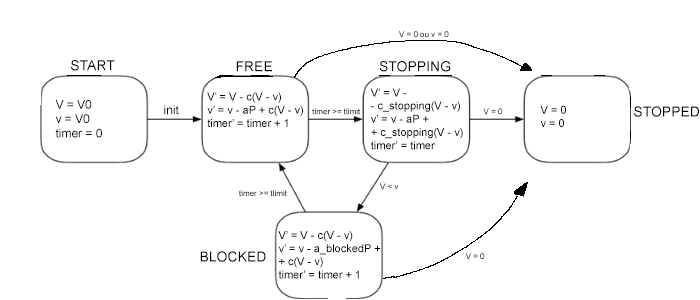

Inicialmente a velocidade do carro (*V*) e das rodas (*v*) será igual a V0 e o timer estará em 0, depois o carro entra no modo **FREE** onde permanece até *V* ou *v* igualarem a 0, nesse caso vai para o modo **STOPPED**, ou até o timer chegar ao limite (este vai incrementando por cada transição de **FREE** para **FREE**) onde vai mudar para o modo **STOPPING**. A partir do modo **STOPPING** poderá haver transição para o modo **STOPPED** caso *V* atinja 0 ou,para o modo **BLOCKED** caso *V* se torne menor que *v* (os valores das velocidades se cruzem). Em **BLOCKED** caso o timer atinja o limite há transição para o modo **FREE**, caso antes disso *V* se iguale a 0 acaba-se no modo **STOPPED**.

No autómato híbrido temos as seguintes variáveis contínuas:

+ **V** $\rightarrow$ Velocidade do corpo do carro
+ **v** $\rightarrow$ Velocidade das rodas do carro
+ **timer** $\rightarrow$ Controla o tempo que se fica nos modos FREE e BLOCKED

Predicados que são usados:

Estado inicial: 

$$m = START \wedge t = 0 \wedge timer = 0 \wedge v = V_{0} \wedge V = V_{0}$$

Transições untimed:

$$m = START \wedge m' = FREE \wedge t' = t \wedge V' = V \wedge v' = v \wedge timer' = timer$$
$$\vee$$
$$m = FREE \wedge m' = STOPPING \wedge t' = t \wedge V' = c(V - v) \wedge v' = aP + c(V - v) \wedge V' \gt erro \wedge v' \gt erro \wedge timer \ge tlimit \wedge timer' = 0$$
$$\vee$$
$$m = STOPPING \wedge m' = BLOCKED \wedge t' = 0 \wedge V' = v - ablockedP \wedge v' = v - ablockedP \wedge V \le v + erro \wedge \wedge V \gt erro \wedge timer' = 0$$
$$\vee$$
$$m = BLOCKED \wedge m' = FREE \wedge t' = t \wedge V' = V \wedge v' = v \wedge timer \ge tlimit \wedge timer' = 0$$
$$\vee$$
$$m = STOPPING \wedge m' = STOPPED \wedge t' = t \wedge V \le erro \wedge v \le erro \wedge V' = v' \wedge V' = 0 \wedge timer' = 0$$
$$\vee$$
$$m = FREE \wedge m' = STOPPED \wedge t' = t \wedge (V - c(V-v) \le erro \vee v - aP + c(V - v \le erro)) \wedge V' = v' \wedge V' = 0 \wedge timer' = 0$$
$$\vee$$
$$m = BLOCKED \wedge m' = STOPPED \wedge t' = t \wedge V - ablockedP \le erro \wedge v - ablockedP \le erro \wedge V' = 0 \wedge v' = 0 \wedge timer' = 0$$

Transições timed:

$$m = FREE \wedge m' = FREE \wedge t' = t + 1\wedge timer' \lt tlimit \wedge timer' = timer + 1 \wedge V' = V - c(V - v) \wedge v' = v - aP + c(V - v) \wedge V' \gt erro \wedge v' \gt erro$$
$$\vee$$
$$m = STOPPING \wedge m' = STOPPING \wedge t' = t + 1 \wedge timer' = timer \wedge V' = V - cstopping(V - v) \wedge v' = v - aP + cstopping(V - v) \wedge V \gt v + erro \wedge v \le V$$
$$\vee$$
$$m = BLOCKED \wedge m' = BLOCKED \wedge t' = t + 1\wedge timer' \le tlimit \wedge timer' = timer + 1 \wedge V' = V - c(V - v) \wedge \wedge V' \gt erro \wedge v' \gt erro$$

# Implementação em python

In [12]:
from pysmt.shortcuts import *
from pysmt.typing import *

V0 = 20


START = Int(-1)
FREE = Int(0)
STOPPING = Int(1)
BLOCKED = Int(2)
STOPPED = Int(3)

P = 1000
c = 0.7
c_stopping = 2
a = 0.01
a_blocked = 0.007
tlimit = 4
erro = 0.1

## `declare`

Criar um dicionário que terá todas as variáveis e os seus respetivos valores em cada estado

In [13]:
def declare(i):
    state = {}
    state['m'] = Symbol('m'+str(i),INT)
    state['V'] = Symbol('V'+str(i),REAL)
    state['v'] = Symbol('v'+str(i),REAL)
    state['timer'] = Symbol('timer'+str(i),REAL)
    state['t'] = Symbol('t'+str(i),REAL)
    return state

## `init`
Verifica se um certo estado é um estado inicial

## `trans`
Verifica, a partir de um estado, que transição é possível este fazer

In [14]:
def init(state):
    return And(Equals(state['m'],START),
               Equals(state['timer'],Real(0)),
               Equals(state['t'],Real(0)),
               Equals(state['v'],Real(V0)),
               Equals(state['V'],Real(V0)))

def trans(curr,prox):

    start_free = And(Equals(curr['m'],START),Equals(prox['m'],FREE),
                     Equals(prox['t'],curr['t']),
                     Equals(prox['V'],curr['V']),
                     Equals(prox['v'],curr['v']),
                     Equals(prox['timer'],Real(0)),
                     Equals(prox['t'],Real(0)))
    
    free_stopped = And(Equals(curr['m'],FREE),Equals(prox['m'],STOPPED),
                       Equals(prox['t'],curr['t']),
                       Or(LE(curr['V'] - Real(c) * (curr['V'] - curr['v']),Real(erro)),
                       LE(curr['v'] - Real(a)*Real(P) + Real(c) * (curr['V'] - curr['v']),Real(erro))),
                       Equals(prox['V'],prox['v']),
                       Equals(prox['V'],Real(0)),
                       Equals(prox['timer'],Real(0)))
    
    free_stopping = And(Equals(curr['m'],FREE),Equals(prox['m'],STOPPING),
                        Equals(prox['t'],curr['t']),
                        GT(curr['V'] - Real(c) * (curr['V'] - curr['v']),Real(erro)),
                        GT(curr['v'] - Real(a)*Real(P) + Real(c) * (curr['V'] - curr['v']),Real(erro)),
                        Equals(prox['V'],curr['V'] - Real(c_stopping) * (curr['V'] - curr['v'])),
                        Equals(prox['v'],curr['v'] - Real(a)*Real(P) + Real(c) * (curr['V'] - curr['v'])),
                        GE(curr['timer'],Real(tlimit)),
                        Equals(prox['timer'],Real(0)))
    
    stopping_stopped = And(Equals(curr['m'],STOPPING),Equals(prox['m'],STOPPED),
                           Equals(prox['t'],curr['t']),
                           LE(curr['V'],Real(erro)),
                           Equals(prox['v'],Real(0)),
                           Equals(prox['V'],Real(0)),
                           Equals(prox['timer'],Real(0)))
    
    stopping_blocked = And(Equals(curr['m'],STOPPING),Equals(prox['m'],BLOCKED),
                           Equals(prox['t'],curr['t']),
                           Equals(prox['V'], curr['v'] - Real(a_blocked)*Real(P)),
                           Equals(prox['v'], curr['v'] - Real(a_blocked)*Real(P)),
                           LE(curr['V'],curr['v'] + Real(erro)),
                           GT(curr['V'],Real(erro)),
                           Equals(prox['timer'],Real(0)))
    
    blocked_free = And(Equals(curr['m'],BLOCKED),Equals(prox['m'],FREE),
                       Equals(prox['t'],curr['t']),
                       Equals(prox['V'],curr['V']),
                       Equals(prox['v'],curr['v']),
                       GE(curr['timer'],Real(tlimit)),
                       Equals(prox['timer'],Real(0)))
    
    
    blocked_stopped = And(Equals(curr['m'],BLOCKED),Equals(prox['m'],STOPPED),
                          Equals(prox['t'],curr['t']),
                          LE(curr['v'] - Real(a_blocked)*Real(P),Real(erro)),
                          LE(curr['V'] - Real(a_blocked)*Real(P),Real(erro)),
                          Equals(prox['v'],Real(0)),
                          Equals(prox['V'],Real(0)),
                          Equals(prox['timer'],Real(0)))
                           

    free_free = And(Equals(curr['m'],FREE),Equals(prox['m'],FREE),
                    Equals(prox['t'],curr['t'] + 1),
                    Equals(prox['timer'],curr['timer'] + Real(1)),
                    LT(curr['timer'],Real(tlimit)),
                    Equals(prox['V'],(curr['V'] - Real(c) * (curr['V'] - curr['v']))),
                    Equals(prox['v'],(curr['v'] - Real(a)*Real(P) + Real(c) * (curr['V'] - curr['v']))),
                    GT(prox['V'],Real(erro)),
                    GT(prox['v'],Real(erro)))
    
    stopping_stopping = And(Equals(curr['m'],STOPPING),Equals(prox['m'],STOPPING),
                            Equals(prox['t'],curr['t'] + 1),
                            Equals(prox['timer'],curr['timer']),
                            Equals(prox['V'],curr['V'] - Real(c_stopping) * (curr['V'] - curr['v'])),
                            Equals(prox['v'],(curr['v'] - Real(a)*Real(P) + Real(c_stopping) * (curr['V'] - curr['v']))),
                            GT(curr['V'],curr['v'] + Real(erro)),
                            LE(curr['v'],curr['V']))
    
    blocked_blocked = And(Equals(curr['m'],BLOCKED),Equals(prox['m'],BLOCKED),
                          Equals(prox['t'],curr['t'] + 1),
                          Equals(prox['timer'],curr['timer'] + Real(1)),
                          LE(prox['timer'],Real(tlimit)),
                          Equals(prox['V'], curr['v'] - Real(a_blocked)*Real(P)),
                          Equals(prox['v'], curr['v'] - Real(a_blocked)*Real(P)),
                          GE(prox['V'],Real(erro)),
                          GE(prox['v'],Real(erro)))
    
    
    return Or(start_free,free_stopping,stopping_blocked,blocked_free,stopping_stopped,free_stopped,blocked_stopped,free_free,stopping_stopping,blocked_blocked)

## `gera_traco`

É criado um possível traço com **k** estados a partir do `declare`, `init` e `trans` declarados anteriormente

In [20]:
def gera_traco(declare,init,trans,k):
    with Solver(name="z3") as s:
        
        trace = [declare(i) for i in range(k)]
        
        s.add_assertion(init(trace[0]))
        for i in range(k-1):
            s.add_assertion(trans(trace[i],trace[i+1]))
            
        if s.solve():
            for i in range(k):
                print()
                print("State:",i)
                m = s.get_py_value(trace[i]['m'])
                if m == -1:
                    print("START")
                elif m == 0:
                    print("FREE")
                elif m == 1:
                    print("STOPPING")
                elif m == 2:
                    print("BLOCKED")
                else:
                    print("STOPPED")
                print("v =", float(s.get_py_value(trace[i]['v'])))
                print("V =", float(s.get_py_value(trace[i]['V'])))
                print("t =", float(s.get_py_value(trace[i]['t'])))
                print("timer =", float(s.get_py_value(trace[i]['timer'])))
                
        else:
            print("Não foi possível resolver")
        
gera_traco(declare,init,trans,6)


State: 0
START
v = 20.0
V = 20.0
t = 0.0
timer = 0.0

State: 1
FREE
v = 20.0
V = 20.0
t = 0.0
timer = 0.0

State: 2
FREE
v = 10.0
V = 20.0
t = 1.0
timer = 1.0

State: 3
FREE
v = 6.999999999999999
V = 13.0
t = 2.0
timer = 2.0

State: 4
FREE
v = 1.1999999999999995
V = 8.8
t = 3.0
timer = 3.0

State: 5
STOPPED
v = 0.0
V = 0.0
t = 3.0
timer = 0.0


## Modelação em lógica temporal linear

1. O veículo imobiliza-se completamente em menos de t segundos 

Para tal, adicionámos ao autómato híbrido uma variável contínua nova **t** que é parecida com o **timer** mas, contará o passar do tempo por todo o percurso do autómato.

Com essa nova variável então, definimos agora o invariante `imobiliza`que, encontrando um t que seja maior ou igual a um certo **k** (3 neste caso), o carro tem que estar no estado **STOPPED**.

$$t \ge 3 \implies m = STOPPED$$

In [5]:
def imobiliza(state):
    return Implies(state['t'] >= 10, Equals(state['m'],STOPPED))    

In [6]:
def bmc_always(declare,init,trans,inv,K):
    for k in range(1,K+1):
        with Solver(name="z3") as s:
            
            trace = [declare(i) for i in range(k)]
        
            s.add_assertion(init(trace[0]))
            for i in range(k-1):
                s.add_assertion(trans(trace[i],trace[i+1]))
                
            s.add_assertion(Not(inv(trace[-1])))
        
            if s.solve():
                for i in range(k):
                    print()
                    print("State:",i)
                    m = s.get_py_value(trace[i]['m'])
                    if m == -1:
                        print("START")
                    elif m == 0:
                        print("FREE")
                    elif m == 1:
                        print("STOPPING")
                    elif m == 2:
                        print("BLOCKED")
                    else:
                        print("STOPPED")
                    print("v =", float(s.get_py_value(trace[i]['v'])))
                    print("V =", float(s.get_py_value(trace[i]['V'])))
                    print("t =", float(s.get_py_value(trace[i]['t'])))
                    print("timer =", float(s.get_py_value(trace[i]['timer'])))
                return
    print(f"A propriedade é válida para traços de tamanho até {k}")

bmc_always(declare,init,trans,imobiliza,12)

A propriedade é válida para traços de tamanho até 12


2. A velocidade V diminui sempre com o tempo

Para isto, foi definido o invariante `Vdiminui` que então verificará que o próximo V será menor que o atual caso o próximo t seja maior que o atual.
$$t' > t \implies V' < V \wedge t > t' \implies V < V'$$

In [10]:
def Vdiminui(curr,prox):
    return And(Implies(And(prox['t'] > curr['t'],curr['t'] > Real(3)),prox['V'] < curr['V'])) 

In [11]:
def bmc_always_d(declare,init,trans,inv,K):
    for k in range(2,K+1):
        with Solver(name="z3") as s:
            
            trace = [declare(i) for i in range(k)]
    
            s.add_assertion(init(trace[0]))
            for i in range(k-1):
                s.add_assertion(trans(trace[i],trace[i+1]))
                
            s.add_assertion(Not(inv(trace[-2],trace[-1])))
        
            if s.solve():
                for i in range(k):
                    print()
                    print("State:",i)
                    m = s.get_py_value(trace[i]['m'])
                    if m == -1:
                        print("START")
                    elif m == 0:
                        print("FREE")
                    elif m == 1:
                        print("STOPPING")
                    elif m == 2:
                        print("BLOCKED")
                    else:
                        print("STOPPED")
                    print("v =", float(s.get_py_value(trace[i]['v'])))
                    print("V =", float(s.get_py_value(trace[i]['V'])))
                    print("t =", float(s.get_py_value(trace[i]['t'])))
                    print("timer =", float(s.get_py_value(trace[i]['timer'])))
                return
    print(f"A propriedade é válida para traços de tamanho até {k}")

bmc_always_d(declare,init,trans,Vdiminui,23)

A propriedade é válida para traços de tamanho até 23


# Exemplo

In [9]:
"""
V0 = 60


State: 0
START
v = 60.0
V = 60.0
t = 0.0
timer = 0.0

State: 1
FREE
v = 60.0
V = 60.0
t = 0.0
timer = 0.0

State: 2
FREE
v = 50.0
V = 60.0
t = 1.0
timer = 1.0

State: 3
FREE
v = 47.0
V = 53.0
t = 2.0
timer = 2.0

State: 4
FREE
v = 41.2
V = 48.8
t = 3.0
timer = 3.0

State: 5
FREE
v = 36.519999999999996
V = 43.48
t = 4.0
timer = 4.0

State: 6
STOPPING
v = 31.392
V = 29.56
t = 4.0
timer = 0.0

State: 7
BLOCKED
v = 24.392
V = 24.392
t = 4.0
timer = 0.0

State: 8
BLOCKED
v = 17.392
V = 17.392
t = 5.0
timer = 1.0

State: 9
BLOCKED
v = 10.392
V = 10.392
t = 6.0
timer = 2.0

State: 10
BLOCKED
v = 3.3919999999999986
V = 3.3919999999999986
t = 7.0
timer = 3.0

State: 11
STOPPED
v = 0.0
V = 0.0
t = 7.0
timer = 0.0

---------------------------

A propriedade é válida para traços de tamanho até 12

---------------------------

State: 0
START
v = 60.0
V = 60.0
t = 0.0
timer = 0.0

State: 1
FREE
v = 60.0
V = 60.0
t = 0.0
timer = 0.0

State: 2
FREE
v = 50.0
V = 60.0
t = 1.0
timer = 1.0

SyntaxError: incomplete input (134881699.py, line 1)